In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

2024-12-10 15:33:07.608588: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 15:33:07.788606: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 15:33:07.788646: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 15:33:07.825948: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 15:33:07.906534: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 15:33:07.907930: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Data
---
There are only 101 images on the dataset. Data Augmentation should be a good choice to improve the model's performance.

### Classes:

* Animal
* Archway
* Bicyclist
* Bridge
* Building
* Car
* CartLuggagePram
* Child
* Column_Pole
* Fence
* LaneMkgsDriv
* LaneMkgsNonDriv
* Misc_Text
* MotorcycleScooter
* OtherMoving
* ParkingBlock
* Pedestrian
* Road
* RoadShoulder
* Sidewalk
* SignSymbol
* Sky
* SUVPickupTruck
* TrafficCone
* TrafficLight
* Train
* Tree
* Truck_Bus
* Tunnel
* VegetationMisc
* Void
* Wall

### Preprocessing

In [2]:
# Define routes for the images
dataset_path = '../data/interim/segmentation/'
filenames = os.listdir(dataset_path)
filenames.sort()

image_list = []
masks_list = []
# Read the images in directory. Read only the images with .png extension
for filename in filenames:
    if len(filename.split('.')) > 1 and filename.split('.')[1][:3] == 'png':
        # Separate real images from masks
        if filename.split('.')[0][-2:] == '_L':
            masks_list.append(dataset_path + '/' + filename) # Mask
        else:
            image_list.append(dataset_path + '/' + filename) # Image

# Train-test split: 80-20
train_input_img_paths, val_input_img_paths, train_target_mask_paths, val_target_mask_paths = train_test_split(
    image_list,
    masks_list, 
    test_size=0.2, 
    random_state=42
)

In [3]:
# Function to load data
def load_data(images_path, masks_path):
    samples = {'images': [], 'masks': []}
    # Read and group the images
    for i in range(len(images_path)):
        img = plt.imread(images_path[i])
        mask = plt.imread(masks_path[i])
        img = cv2.resize(img, (256, 256))
        masks = cv2.resize(mask, (256, 256))
        samples['images'].append(img)
        samples['masks'].append(masks)
    # Convert the lists within the dictionary into arrays
    samples = {
        'images': np.array(samples['images']),
        'masks': np.array(samples['masks']),
    }
    return samples

# Read the images
train_samples = load_data(train_input_img_paths, train_target_mask_paths)
test_samples = load_data(val_input_img_paths, val_target_mask_paths)

print(f'Training: {len(train_samples["images"])} images')
print(f'Testing: {len(test_samples["images"])} images')

Training: 80 images
Testing: 21 images


### Image Example

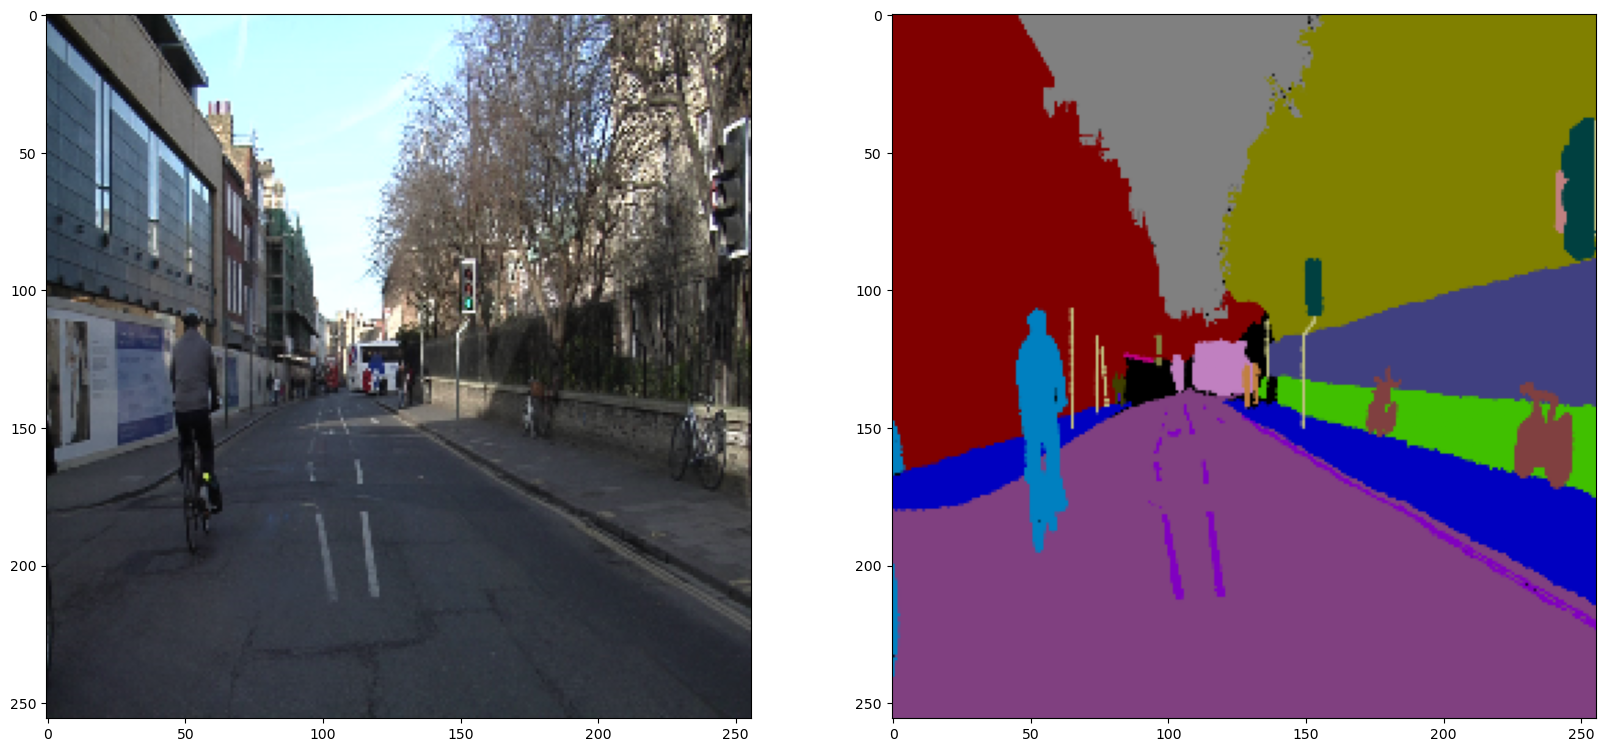

In [4]:
# Visualize a test image: the index must be the same
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(train_samples['images'][10])
plt.subplot(1, 2, 2)
plt.imshow(train_samples['masks'][10])
plt.show()

## Creating U-Net

In [5]:
# Callbacks
checkpoint = ModelCheckpoint(
    '../models/u-net/u_net_v1,0.weights.h5',
    monitor='accuracy', 
    verbose= 1, 
    save_best_only=True,
    save_weights_only=True
)

early_stopping = EarlyStopping(monitor='accuracy', patience=60)

In [6]:
# Convolution Block
def conv_block(input_tensor, num_filters):
    # Conv Layer with Batch Norm and a relu activation
    x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Conv Layer with Batch Norm and a relu activation
    x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x


# U-Net Architecture
def unet(input_shape, num_filters=16, dropout=0.1):
    ### Encoder

    c1 = conv_block(input_shape, num_filters * 1)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(dropout)(p1)
    
    c2 = conv_block(p1, num_filters * 2)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(dropout)(p2)

    c3 = conv_block(p2, num_filters * 4)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(dropout)(p3)

    c4 = conv_block(p3, num_filters * 8)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(dropout)(p4)

    c5 = conv_block(p4, num_filters * 16)

    ### Decoder
    u6 = tf.keras.layers.Convolution2DTranspose(num_filters*8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(dropout)(u6)
    c6 = conv_block(u6, num_filters*8)

    u7 = tf.keras.layers.Convolution2DTranspose(num_filters*4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(dropout)(u7)
    c7 = conv_block(u7, num_filters*4)

    u8 = tf.keras.layers.Convolution2DTranspose(num_filters*2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(dropout)(u8)
    c8 = conv_block(u8, num_filters*2)

    u9 = tf.keras.layers.Convolution2DTranspose(num_filters*1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(dropout)(u9)
    c9 = conv_block(u9, num_filters*1)

    ### Classification
    output = tf.keras.layers.Conv2D(3, (1, 1), activation='sigmoid')(c9)
    model = tf.keras.Model(inputs = [input_shape], outputs = [output])

    return model 

In [7]:
inputs = tf.keras.layers.Input((256, 256, 3))
model = unet(inputs)

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

2024-12-10 15:33:16.304491: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-10 15:33:16.304690: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 16)         0         ['batch_normalization[0][0

In [8]:
model_history = model.fit(
    train_samples['images'],
    train_samples['masks'], 
    epochs=500, 
    verbose=1, 
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/500
3/3 [==============================] - ETA: 0s - loss: 0.7711 - accuracy: 0.7778
Epoch 1: accuracy improved from -inf to 0.77785, saving model to ../models/u-net/u_net_v1,0.weights.h5
3/3 [==============================] - 16s 4s/step - loss: 0.7711 - accuracy: 0.7778
Epoch 2/500
3/3 [==============================] - ETA: 0s - loss: 0.7219 - accuracy: 0.7784
Epoch 2: accuracy improved from 0.77785 to 0.77842, saving model to ../models/u-net/u_net_v1,0.weights.h5
3/3 [==============================] - 12s 4s/step - loss: 0.7219 - accuracy: 0.7784
Epoch 3/500
3/3 [==============================] - ETA: 0s - loss: 0.6913 - accuracy: 0.7799
Epoch 3: accuracy improved from 0.77842 to 0.77994, saving model to ../models/u-net/u_net_v1,0.weights.h5
3/3 [==============================] - 12s 4s/step - loss: 0.6913 - accuracy: 0.7799
Epoch 4/500
3/3 [==============================] - ETA: 0s - loss: 0.6725 - accuracy: 0.7817
Epoch 4: accuracy improved from 0.77994 to 0.78173, saving

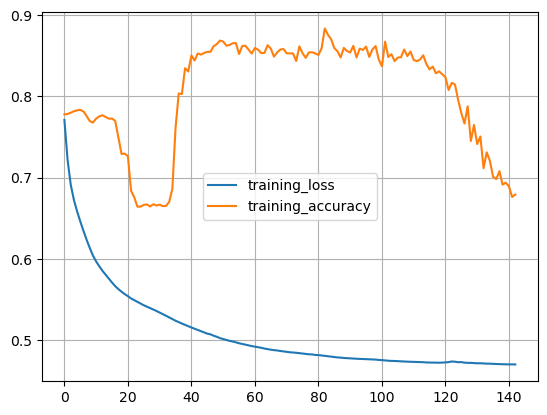

In [9]:
# Loss and accuracy
plt.plot(model_history.history['loss'], label='training_loss')
plt.plot(model_history.history['accuracy'], label='training_accuracy')
plt.legend()
plt.grid(True)

## Evaluation

1/1 [==============================] - 1s 715ms/step


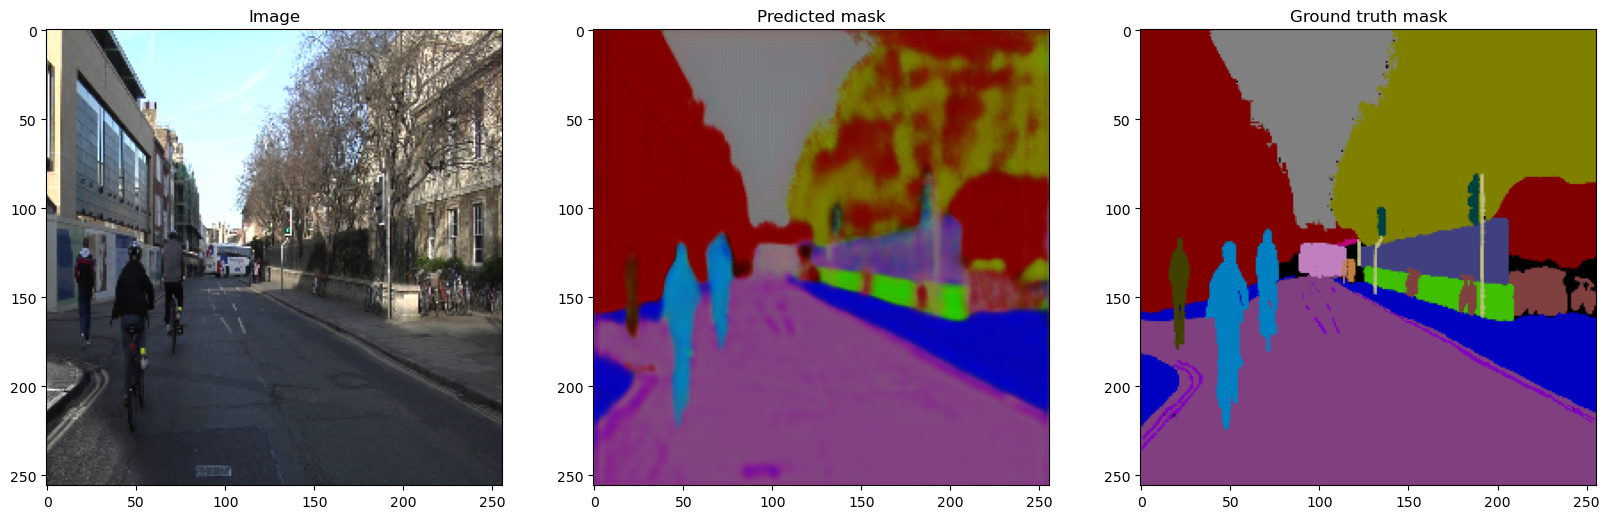

In [10]:
# Predictions 
def predict_test_samples(val_map, model):
    img = val_map['images']
    mask = val_map['masks']

    test_images = np.array(img)

    predictions = model.predict(test_images)

    return predictions,  test_images, mask


# Visualization: Image, Predicted Mask, Ground-Truth Mask
def plot_images(test_image, predicted_maks, ground_truth):
    plt.figure(figsize=(20, 20))

    plt.subplot(1, 3, 1)
    plt.imshow(test_image)
    plt.title('Image')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_maks)
    plt.title('Predicted mask')

    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth)
    plt.title('Ground truth mask')


predicted_masks, test_images, ground_truth_masks = predict_test_samples(test_samples, model)
plot_images(test_images[20], predicted_masks[20], ground_truth_masks[20])

In [11]:
# Evaluate the model at the whole test set
model2 = model
model2.load_weights('../models/u-net/u_net_v1,0.weights.h5')
model2.evaluate(test_samples['images'], test_samples['masks'])

1/1 [==============================] - 1s 689ms/step - loss: 0.5579 - accuracy: 0.8284


[0.5578743815422058, 0.8284367322921753]